# Clinical Triage Text Datasets — Standardization Pipeline Demo

**What this artifact does:** Standardizes 5 clinical/medical text classification datasets into a unified schema for the Cross-Representation Neighborhood Dissonance (CRND) pipeline. Each dataset contains free-text clinical inputs with categorical severity/disease labels.

**Datasets included:**
1. `medical_abstracts` — PubMed abstracts across 5 disease categories
2. `mimic_iv_ed_demo` — ED triage records with ESI acuity levels
3. `clinical_patient_triage_nl` — Synthetic triage vignettes with 6 severity levels
4. `ohsumed_single` — MEDLINE abstracts across 23 MeSH disease categories
5. `mental_health_conditions` — Social media posts across 7 mental health conditions

**Schema:** `{"datasets": [{"dataset": "name", "examples": [{"input": "text", "output": "label", ...}]}]}`

In [1]:
import subprocess, sys
def _pip(*a): subprocess.check_call([sys.executable, '-m', 'pip', 'install', '-q', *a])

# All packages used (json, csv, random, collections, time, pathlib) are stdlib — no non-Colab packages needed

# Core packages: pre-installed on Colab, install locally to match Colab env
if 'google.colab' not in sys.modules:
    _pip('numpy==2.0.2', 'pandas==2.2.2', 'matplotlib==3.10.0')


[notice] A new release of pip is available: 25.0.1 -> 26.0.1
[notice] To update, run: python3.12 -m pip install --upgrade pip


In [2]:
import json
import csv
import random
import time
from pathlib import Path
from collections import Counter

import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams['figure.dpi'] = 120

## Data Loading

Load the curated mini demo dataset (66 examples across 5 clinical text datasets). Tries GitHub URL first, falls back to local file.

In [3]:
GITHUB_DATA_URL = "https://raw.githubusercontent.com/AMGrobelnik/ai-invention-e0166a-cross-representation-neighborhood-disson/main/dataset_iter1_clinical_triage/demo/mini_demo_data.json"
import json, os

def load_data():
    try:
        import urllib.request
        with urllib.request.urlopen(GITHUB_DATA_URL) as response:
            return json.loads(response.read().decode())
    except Exception: pass
    if os.path.exists("mini_demo_data.json"):
        with open("mini_demo_data.json") as f: return json.load(f)
    raise FileNotFoundError("Could not load mini_demo_data.json")

In [4]:
data = load_data()
print(f"Loaded {len(data['datasets'])} datasets")
for ds in data['datasets']:
    labels = sorted(set(ex['output'] for ex in ds['examples']))
    print(f"  {ds['dataset']}: {len(ds['examples'])} examples, {len(labels)} classes")

Loaded 5 datasets
  medical_abstracts: 15 examples, 5 classes
  mimic_iv_ed_demo: 11 examples, 4 classes
  clinical_patient_triage_nl: 11 examples, 6 classes
  ohsumed_single: 15 examples, 12 classes
  mental_health_conditions: 14 examples, 7 classes


## Configuration

Tunable parameters for the standardization pipeline. `MAX_SAMPLES_PER_DATASET` controls the maximum examples retained per dataset after stratified subsampling.

In [5]:
# ── Config ──────────────────────────────────────────────────────
# Original value used in full pipeline (with 37K total examples):
MAX_SAMPLES_PER_DATASET = 15000  # Cap per dataset after stratified subsampling
# Demo data has ~66 examples total, so this cap is not triggered

## Helper Functions

Core utilities from the original pipeline: logging with elapsed time, and stratified subsampling to balance class distributions when capping dataset sizes.

In [6]:
start_time = time.time()


def log(msg: str) -> None:
    elapsed = time.time() - start_time
    print(f"[{elapsed:7.1f}s] {msg}", flush=True)


def load_json(path: Path) -> list:
    """Load a JSON file that contains a top-level array."""
    with open(path, "r", encoding="utf-8") as f:
        return json.load(f)


def stratified_subsample(examples: list, max_n: int) -> list:
    """Subsample examples stratified by 'output' field."""
    if len(examples) <= max_n:
        return examples

    random.seed(42)

    # Group by output label
    by_label: dict[str, list] = {}
    for ex in examples:
        label = ex["output"]
        by_label.setdefault(label, []).append(ex)

    # Calculate per-label allocation (proportional)
    n_labels = len(by_label)
    result = []
    remaining = max_n
    labels = sorted(by_label.keys())

    for i, label in enumerate(labels):
        group = by_label[label]
        if i == len(labels) - 1:
            n_take = remaining
        else:
            n_take = max(1, round(len(group) / len(examples) * max_n))
            n_take = min(n_take, remaining, len(group))
        random.shuffle(group)
        result.extend(group[:n_take])
        remaining -= min(n_take, len(group))

    random.shuffle(result)
    return result

## Dataset Processing

Process each of the 5 datasets from the loaded data. Each processor standardizes the raw examples into the unified schema: `{"input": text, "output": label, "metadata_*": ...}`. Stratified subsampling is applied to large datasets to cap at `MAX_SAMPLES_PER_DATASET`.

In [7]:
def process_dataset(ds_entry: dict) -> dict:
    """Process a single dataset entry from the loaded data.
    
    In the original pipeline, each dataset has its own processor that reads
    raw files (CSV, JSON) and standardizes them. Here we demonstrate the
    standardization logic on the already-loaded mini demo data.
    """
    name = ds_entry["dataset"]
    examples = ds_entry["examples"]
    log(f"Processing {name}...")
    log(f"  Loaded: {len(examples)} examples")

    # Apply stratified subsampling (same as original pipeline)
    examples = stratified_subsample(examples, max_n=MAX_SAMPLES_PER_DATASET)

    # Validate schema: every example must have 'input' and 'output'
    valid = []
    for ex in examples:
        if ex.get("input") and ex.get("output"):
            valid.append(ex)
    examples = valid

    log(f"  Final: {len(examples)} examples")
    return {"dataset": name, "examples": examples}


# Process all datasets
log("Starting dataset standardization pipeline")
processed_datasets = []

for ds_entry in data["datasets"]:
    try:
        result = process_dataset(ds_entry)
        if result["examples"]:
            processed_datasets.append(result)
            log(f"  ✓ {result['dataset']}: {len(result['examples'])} examples")
        else:
            log(f"  ✗ {result['dataset']}: no valid examples, skipping")
    except Exception as e:
        log(f"  ✗ ERROR in {ds_entry['dataset']}: {e}")
        import traceback
        traceback.print_exc()

output = {"datasets": processed_datasets}

[    0.0s] Starting dataset standardization pipeline


[    0.0s] Processing medical_abstracts...


[    0.0s]   Loaded: 15 examples


[    0.0s]   Final: 15 examples


[    0.0s]   ✓ medical_abstracts: 15 examples


[    0.0s] Processing mimic_iv_ed_demo...


[    0.0s]   Loaded: 11 examples


[    0.0s]   Final: 11 examples


[    0.0s]   ✓ mimic_iv_ed_demo: 11 examples


[    0.0s] Processing clinical_patient_triage_nl...


[    0.0s]   Loaded: 11 examples


[    0.0s]   Final: 11 examples


[    0.0s]   ✓ clinical_patient_triage_nl: 11 examples


[    0.0s] Processing ohsumed_single...


[    0.0s]   Loaded: 15 examples


[    0.0s]   Final: 15 examples


[    0.0s]   ✓ ohsumed_single: 15 examples


[    0.0s] Processing mental_health_conditions...


[    0.0s]   Loaded: 14 examples


[    0.0s]   Final: 14 examples


[    0.0s]   ✓ mental_health_conditions: 14 examples


## Summary

Aggregate statistics across all processed datasets: total examples, classes per dataset, and text length distributions.

In [8]:
# Summary table
log("=" * 60)
log("SUMMARY")
log("=" * 60)
total = 0
summary_rows = []
for ds in output["datasets"]:
    n = len(ds["examples"])
    total += n
    labels = set(ex["output"] for ex in ds["examples"])
    text_lengths = [len(ex["input"]) for ex in ds["examples"]]
    avg_len = sum(text_lengths) / len(text_lengths) if text_lengths else 0
    log(f"  {ds['dataset']:40s} | {n:6d} examples | {len(labels):3d} classes")
    summary_rows.append({
        "dataset": ds["dataset"],
        "n_examples": n,
        "n_classes": len(labels),
        "avg_text_len": round(avg_len, 1),
        "min_text_len": min(text_lengths) if text_lengths else 0,
        "max_text_len": max(text_lengths) if text_lengths else 0,
    })

log(f"  {'TOTAL':40s} | {total:6d} examples | {len(output['datasets']):3d} datasets")

# Display as pandas DataFrame
df_summary = pd.DataFrame(summary_rows)
print("\n")
print(df_summary.to_string(index=False))

elapsed = time.time() - start_time
log(f"Done in {elapsed:.1f}s")

[    0.0s] ============================================================


[    0.0s] SUMMARY


[    0.0s] ============================================================


[    0.0s]   medical_abstracts                        |     15 examples |   5 classes


[    0.0s]   mimic_iv_ed_demo                         |     11 examples |   4 classes


[    0.0s]   clinical_patient_triage_nl               |     11 examples |   6 classes


[    0.0s]   ohsumed_single                           |     15 examples |  12 classes


[    0.0s]   mental_health_conditions                 |     14 examples |   7 classes


[    0.0s]   TOTAL                                    |     66 examples |   5 datasets




                   dataset  n_examples  n_classes  avg_text_len  min_text_len  max_text_len
         medical_abstracts          15          5         400.0           400           400
          mimic_iv_ed_demo          11          4          90.3            41           106
clinical_patient_triage_nl          11          6         130.8           114           144
            ohsumed_single          15         12         400.0           400           400
  mental_health_conditions          14          7         242.8            51           400
[    0.1s] Done in 0.1s


## Visualization

Two views of the standardized data:
1. **Class distribution** per dataset — bar chart showing label counts
2. **Text length distribution** per dataset — box plot of input character lengths

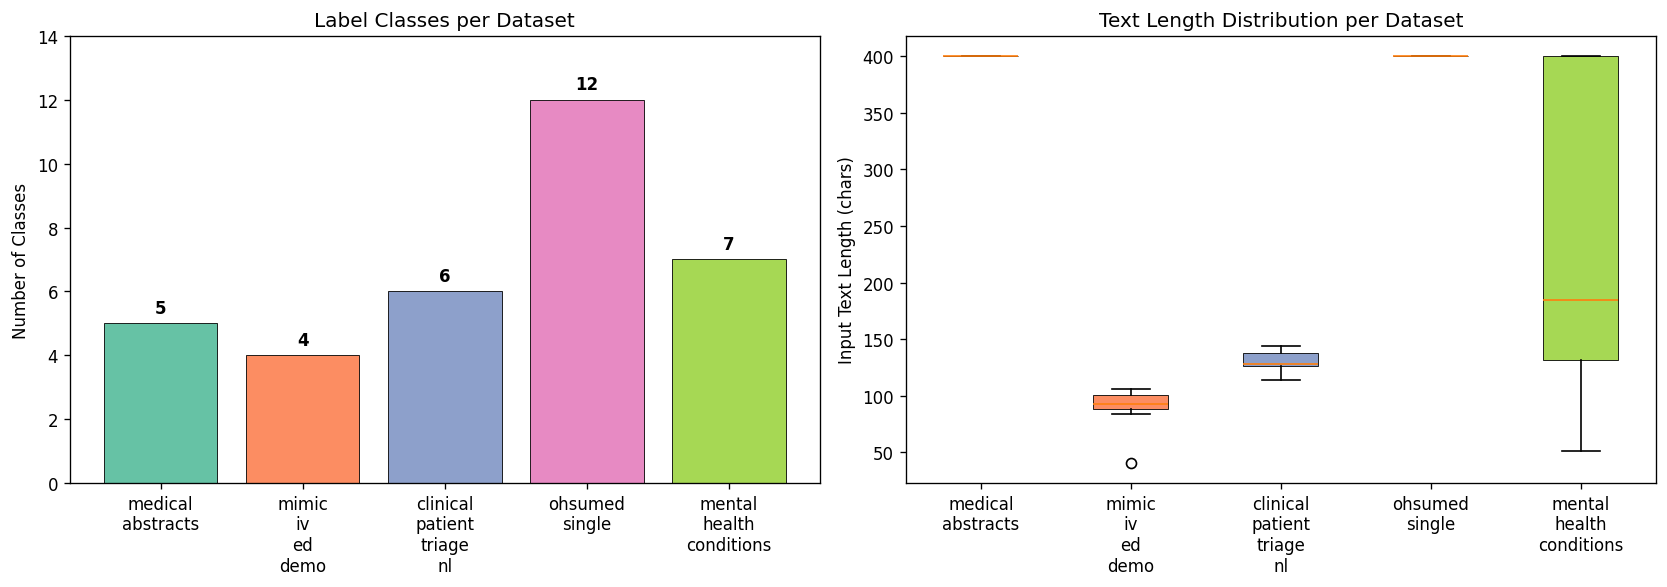


── Sample Examples ──

[medical_abstracts] label=Digestive_system_diseases
  Factors influencing the development of metabolic bone disease in primary biliary cirrhosis. The prevalence, type, and fa...

[mimic_iv_ed_demo] label=ESI-3
  Chief complaint: Hypertension. Vitals: HR 65, RR 18, BP 218/72, Temp 97.5, O2 96%, Pain 0/10

[clinical_patient_triage_nl] label=Moderate
  Chronic lower back pain exacerbated by lifting heavy object; no numbness. Age: 45. Vital signs: Stable. Primary complain...


In [9]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# ── Plot 1: Class distribution per dataset ──
ds_names = []
ds_class_counts = []
colors = plt.cm.Set2.colors

for ds in output["datasets"]:
    ds_names.append(ds["dataset"].replace("_", "\n"))
    ds_class_counts.append(len(set(ex["output"] for ex in ds["examples"])))

bars = axes[0].bar(ds_names, ds_class_counts, color=colors[:len(ds_names)], edgecolor="black", linewidth=0.5)
axes[0].set_ylabel("Number of Classes")
axes[0].set_title("Label Classes per Dataset")
for bar, count in zip(bars, ds_class_counts):
    axes[0].text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.2,
                 str(count), ha="center", va="bottom", fontweight="bold", fontsize=10)
axes[0].set_ylim(0, max(ds_class_counts) + 2)

# ── Plot 2: Text length distribution per dataset ──
text_lengths_by_ds = []
ds_labels = []
for ds in output["datasets"]:
    lengths = [len(ex["input"]) for ex in ds["examples"]]
    text_lengths_by_ds.append(lengths)
    ds_labels.append(ds["dataset"].replace("_", "\n"))

bp = axes[1].boxplot(text_lengths_by_ds, tick_labels=ds_labels, patch_artist=True)
for patch, color in zip(bp["boxes"], colors[:len(ds_labels)]):
    patch.set_facecolor(color)
    patch.set_edgecolor("black")
    patch.set_linewidth(0.5)
axes[1].set_ylabel("Input Text Length (chars)")
axes[1].set_title("Text Length Distribution per Dataset")

plt.tight_layout()
plt.show()

# Print sample examples
print("\n── Sample Examples ──")
for ds in output["datasets"][:3]:
    ex = ds["examples"][0]
    snippet = ex["input"][:120] + ("..." if len(ex["input"]) > 120 else "")
    print(f"\n[{ds['dataset']}] label={ex['output']}")
    print(f"  {snippet}")